# Анализ пользовательского поведения в мобильном приложении
## Описание проекта
Стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

1. Изучить воронку продаж. 

    - как пользователи доходят до покупки;
    - сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах;
    - на каких шагах застревают.


2. Исследовать результаты A/A/B-эксперимента

    **Условия**: дизайнеры хотят поменять шрифты во всём приложении, а менеджеры опасаются, что пользователям будет непривычно. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 
    - Выяснить, какой шрифт лучше.

<font color = grey><i>Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.</i></font>

## Итоги
Были изучены принципы событийной аналитики. Построена воронка продаж, исследован путь пользователей до покупки. Проанализированы
результаты A/B-теста введения новых шрифтов. Выявлено, что изменение шрифта в приложении не окажет значительного влияния на поведение пользователей. Предоставлены рекомендации.


## Описание данных

Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Содержание
1. [Подготовка данных к исследованию](#header_1)
2. [Анализ данных](#header_2)
    - [Изучение воронки продаж](#header_2_1)
    - [Исследование результатов A/A/B-эксперимента](#header_2_2)  
    
    
3. [Выводы](#header_3)



## Используемые библиотеки и функции

In [1]:
import pandas as pd
import numpy as np
import math as mth
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import plotly.io as pio
png_renderer = pio.renderers["svg"]
png_renderer.width = 1000
png_renderer.height = 500

pio.renderers.default = "svg"

import warnings
warnings.filterwarnings('ignore')

# задаем ширину столбцов датафрейма
pd.options.display.max_colwidth = 150

# лучше set_theme, но в этом окружении не работает
sns.set(context = 'notebook', 
        font_scale = 1, 
        style="whitegrid", 
        palette="Greens",
        rc={'axes.labelsize': 13, 'axes.titlesize': 15, "figure.figsize":(15, 5)} 
       )

# функция для форматирования графиков
def plot_format(title, xlabel, ylabel, tsize = 15):
    '''
    Назначает подписи графика и осей для текущего выбранного графика
    :title: заголовок графика
    :xlabel: подпись оси X
    :ylabel: подпись оси Y
    '''
    plt.title(title, size = tsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
PATH = 'datasets/logs_exp.csv'

# Подготовка данных к исследованию<a id='header_1'></a>

In [5]:
logs = pd.read_csv(PATH, '\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
# приводим названия столбцов к удобному формату
logs.columns = ['event', 'user_id', 'event_dttm', 'group_id']

In [8]:
# переводим время из unix-time в привычное глазу
logs['event_dttm'] = pd.to_datetime(logs['event_dttm'], unit = 's')
logs['event_date'] = logs['event_dttm'].dt.date 
logs.head()

,event,user_id,event_dttm,group_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [9]:
# проверяем поле group_id — нет ли лишних значений 
logs['group_id'].unique()

array([246, 248, 247])

In [10]:
print('Количество полных дублей до:', logs.duplicated().sum())
logs = logs.drop_duplicates()
print('Количество полных дублей после:', logs.duplicated().sum())

Количество полных дублей до: 413
Количество полных дублей после: 0


Проверим, насколько качествено прозведено деление на экспериментальны группы.

In [11]:
# количество пользователей в каждой группе и доля каждой из групп
df = logs.groupby('group_id', as_index = False).agg({'user_id':'nunique'}) 
df['part'] = df['user_id']/df['user_id'].sum()
print('Разница между самой большой и самой маленькой группой {:.2%}'.format(df['user_id'].max()/df['user_id'].min() - 1))
print('Разница между A-группами {:.2%}'.format(df.iloc[1]['user_id']/df.iloc[0]['user_id'] - 1))
df

Разница между самой большой и самой маленькой группой 2.13%
Разница между A-группами 1.25%


,group_id,user_id,part
0,246,2489,0.329625
1,247,2520,0.333731
2,248,2542,0.336644


In [12]:
df[df['group_id']==246]['user_id'].to_numpy()

array([2489])

In [13]:
group_246 = logs[logs['group_id'] == 246][['group_id','user_id']].drop_duplicates()
group_247 = logs[logs['group_id'] == 247][['group_id','user_id']].drop_duplicates()
group_248 = logs[logs['group_id'] == 248][['group_id','user_id']].drop_duplicates()


print('Количество пользователей, попавших и в группу 246, и в группу 247:', 
      group_246.merge(group_247, on = 'user_id')['user_id'].count())
print('Количество пользователей, попавших и в группу 246, и в группу 248:', 
      group_246.merge(group_248, on = 'user_id')['user_id'].count())
print('Количество пользователей, попавших и в группу 247, и в группу 248:', 
      group_247.merge(group_248, on = 'user_id')['user_id'].count())

Количество пользователей, попавших и в группу 246, и в группу 247: 0
Количество пользователей, попавших и в группу 246, и в группу 248: 0
Количество пользователей, попавших и в группу 247, и в группу 248: 0


In [14]:
print('Количество событий в логе:',logs.shape[0])
print('Количество пользователей:', logs['user_id'].unique().shape[0])
print('Среднее количество событий на пользователя: {:.0f}'.format(logs.groupby('user_id')['event'].count().mean()))

print('Минимальная дата события:', logs['event_date'].min())
print('Максимальня дата события:', logs['event_date'].max())

Количество событий в логе: 243713
Количество пользователей: 7551
Среднее количество событий на пользователя: 32
Минимальная дата события: 2019-07-25
Максимальня дата события: 2019-08-07


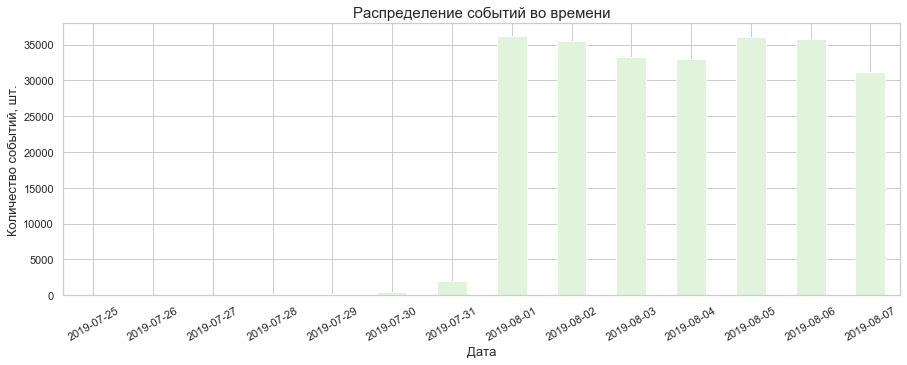

In [15]:
# распределение событий во времени
logs.groupby('event_date')['event'].count().plot(kind = 'bar', rot=30)
plot_format('Распределение событий во времени', 'Дата', 'Количество событий, шт.')

Отбросим старые нерелевантные данные и проверим, что осталось в логе.

In [17]:
logs_correct = logs[logs['event_date'] > pd.to_datetime('2019-07-31', format = '%Y-%m-%d')]

print('Количество событий в скорректированном логе:',logs_correct.shape[0])
print('--> отбросили {:.0f} ({:.2%}) событий'
      .format(logs.shape[0] - logs_correct.shape[0], (logs.shape[0] - logs_correct.shape[0])/logs.shape[0]))
print()

print('Количество пользователей в скорректированном логе:', logs_correct['user_id'].unique().shape[0])
print('--> отбросили {:.0f} ({:.2%}) пользователей'
      .format(logs['user_id'].unique().shape[0] - logs_correct['user_id'].unique().shape[0],
             (logs['user_id'].unique().shape[0] - logs_correct['user_id'].unique().shape[0])/logs['user_id'].unique().shape[0]))
print()

print('Среднее количество событий на пользователя: {:.0f}'.format(logs_correct.groupby('user_id')['event'].count().mean()))

print('Минимальная дата события:', logs_correct['event_date'].min())
print('Максимальня дата события:', logs_correct['event_date'].max())

#количество пользователей в каждой группе
df = logs_correct.groupby('group_id', as_index = False).agg({'user_id':'nunique'}) 
df['part'] = df['user_id']/df['user_id'].sum()
print('Разница между самой большой и самой маленькой группой {:.2%}'.format(df['user_id'].max()/df['user_id'].min() - 1))
print('Разница между A-группами {:.2%}'.format(df.iloc[1]['user_id']/df.iloc[0]['user_id'] - 1))
display(df)

Количество событий в скорректированном логе: 240887
--> отбросили 2826 (1.16%) событий

Количество пользователей в скорректированном логе: 7534
--> отбросили 17 (0.23%) пользователей

Среднее количество событий на пользователя: 32
Минимальная дата события: 2019-08-01
Максимальня дата события: 2019-08-07
Разница между самой большой и самой маленькой группой 2.13%
Разница между A-группами 1.17%


,group_id,user_id,part
0,246,2484,0.329705
1,247,2513,0.333555
2,248,2537,0.336740


Пропуски отсутствуют, полные дубликаы удалены, пользователи поделены на примерно равные группы (разница в числе пользоавтелей не превышает 3%). Пользователи разделены корректно, не попали в две группы сразу.
Реальный период, за который распологаем данными: c 01.08.2019 по 07.08.2019. После того, как отбросили данные, значительных изменений в распределении данных не произошло.

# Анализ данных <a id='header_2'></a>

## Изучение воронки продаж<a id='header_2_1'></a>

In [18]:
# изучаем значения в поле event 
logs_correct['event'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

События расшифруем так:
- MainScreenAppear — просмотр главного экрана
- PaymentScreenSuccessful — успешный платеж
- CartScreenAppear — просмотр корзины
- OffersScreenAppear — просмотр экрана с предложением 
- Tutorial — обучение (велком-сценарий)

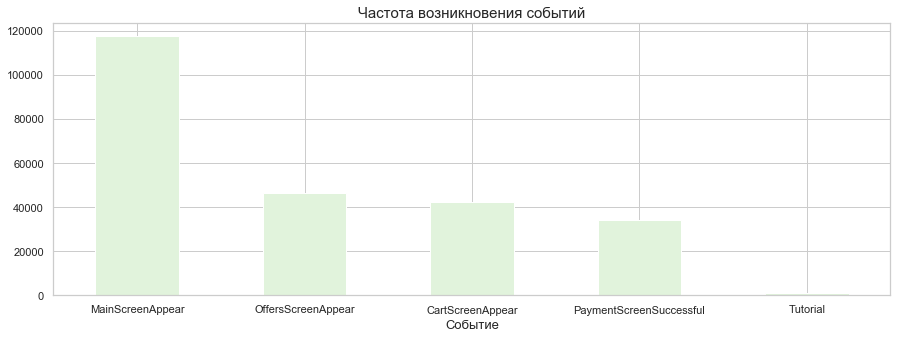

In [19]:
#изучим, как часто возникают события
event_frequency = (logs_correct
                   .groupby('event', as_index = False)['event_date']
                   .count()
                   .sort_values(by = 'event_date', ascending = False)
                  )

ax = event_frequency.plot(kind = 'bar', x = 'event', y = 'event_date', rot = 0, legend = False)
plot_format('Частота возникновения событий', 'Событие', '')

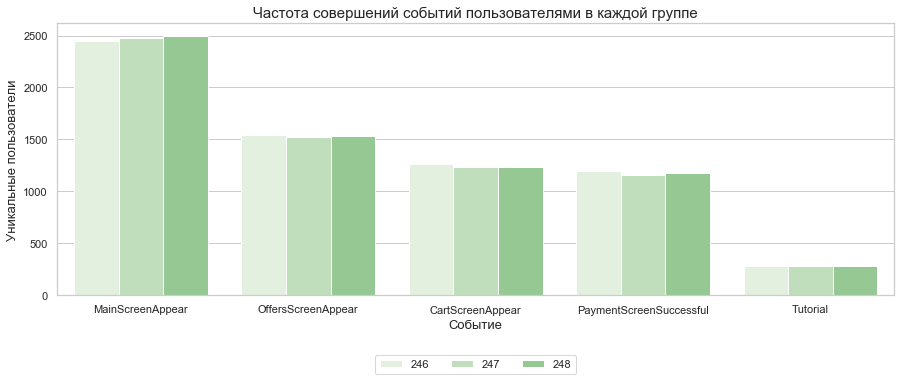

In [20]:
#изучим, сколько пользователей совершали каждое из собыитий в каждой группе
users_x_event = (logs_correct
                 .groupby(['group_id','event'], as_index = False)
                 .agg({'user_id':'nunique'})
                 .sort_values(by = 'user_id', ascending = False)
                 .rename(columns = {'user_id':'event_unique_users'})
                )

sns.barplot(data = users_x_event, x = 'event', y ='event_unique_users', hue = 'group_id')
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.2), ncol=3) #указываем положение легенды
plot_format('Частота совершений событий пользователями в каждой группе', 'Событие', 'Уникальные пользователи')

In [21]:
#вычисляем количество уникальных пользователей в каждой группе
unique_users = (logs_correct.groupby('group_id')
                .agg({'user_id':'nunique'})
                .rename(columns = {'user_id':'group_unique_users'})
               )

#объединим информацию об уникальных пользователях с информацией о совершенных событиях
users_x_event = users_x_event.merge(unique_users, on = 'group_id')

#вычислим долю пользователей, которые хоть раз совершали событие в каждой группе 
users_x_event['part'] = users_x_event['event_unique_users']/users_x_event['group_unique_users']
users_x_event.style.background_gradient(subset = ['part'], cmap='Greens') 

,group_id,event,event_unique_users,group_unique_users,part
0,248,MainScreenAppear,2493,2537,0.982657
1,248,OffersScreenAppear,1531,2537,0.603469
2,248,CartScreenAppear,1230,2537,0.484825
3,248,PaymentScreenSuccessful,1181,2537,0.46551
4,248,Tutorial,279,2537,0.109972
5,247,MainScreenAppear,2476,2513,0.985277
6,247,OffersScreenAppear,1520,2513,0.604855
7,247,CartScreenAppear,1238,2513,0.492638
8,247,PaymentScreenSuccessful,1158,2513,0.460804
9,247,Tutorial,283,2513,0.112614


Количество пользователей на этапах разное. Во всех группах число пользователей уменьшается от этапа к этапу в следующем порядке:
- MainScreenAppear
- OffersScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful	
- Tutorial

С одной стороны можно сказать, что это и есть наша искомая воронка, но последнее событие  в списке (Tutorial) выбивается из общей логики. Воронка должна закончиться на целевом действии - покупке. Скорее всего Tutorial — это обучение, которое пропускает большая часть пользователей. Можем исключить этот этап из воронки, а еще стоит задуматься над необходимостью наличия этого этапа в приложении. Или над инфромативностью этого этапа. 


In [22]:
# удалям этап tutorial
users_x_event = users_x_event[users_x_event['event'] != 'Tutorial'] 

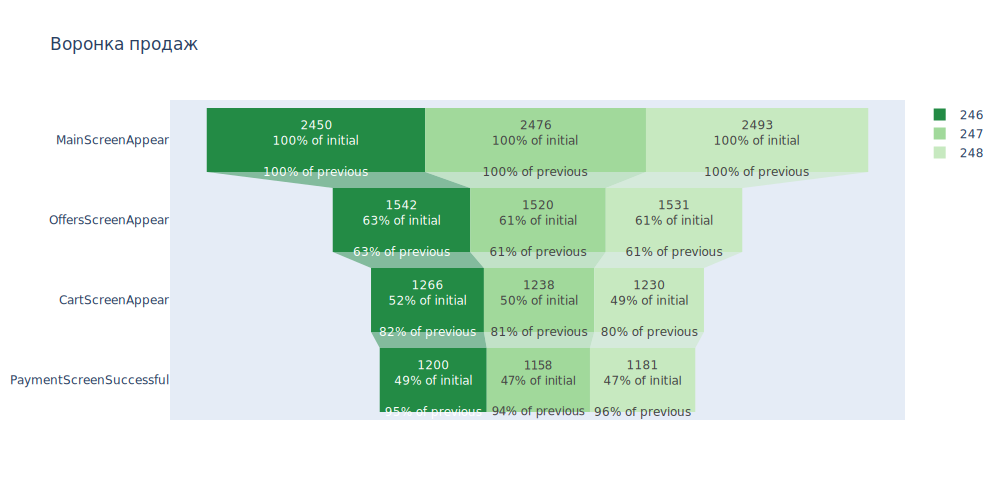

In [23]:
# выделяем массив с названиями этапов и массивы с количеством пользователей на этапах для каждой группы
funnel_steps = users_x_event['event'].unique()
funnel_users_246 = users_x_event[users_x_event['group_id'] == 246]['event_unique_users']
funnel_users_247 = users_x_event[users_x_event['group_id'] == 247]['event_unique_users']
funnel_users_248 = users_x_event[users_x_event['group_id'] == 248]['event_unique_users']

# строим воронку
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = '246',
    y = funnel_steps,  # наименования этапов
    x = funnel_users_246,  # значения на этапах
    # выводить подписи на элементах воронки: значение, %от первого этапа, %от предыдущего этапа
    textinfo = "value+percent initial+percent previous", 
    textposition = 'inside', 
    marker = {"color": "rgb(35,139,69)"},
    hoverinfo = 'none'))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = funnel_steps,
    x = funnel_users_247,
    textinfo = "value+percent initial+percent previous",
    textposition = 'inside',
    marker = {"color": "rgb(161,217,155)"},
    hoverinfo = 'none'))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = funnel_steps,
    x = funnel_users_248,
    textinfo = "value+percent initial+percent previous",
    textposition = 'inside',
    marker = {"color": "rgb(199,233,192)"},
    hoverinfo = 'none'))

fig.update_layout(title="Воронка продаж")

fig.show()

Верно для каждой группы: **больше всего пользователей теряется при переходе не этап "OffersScreenAppear"**: около 40%. При этом, если пользователи перешли на этот этап, то дальнейшая воронка выглядит успешной; а пользователи, которые дошли до этапа корзины, совершают оплату а 95% случаев. 

От первого события до оплаты доходит ~48% пользователей. 

## Исследование результатов A/A/B-эксперимента<a id='header_2_2'></a>

Количество пользователей в каждой из групп:

In [24]:
unique_users

,group_unique_users
group_id,
246,2484
247,2513
248,2537


Создадим объединенную группу из групп 246 и 247:

In [25]:
united_group = users_x_event[(users_x_event['group_id'] == 247) | (users_x_event['group_id'] == 246)]
united_group = united_group[['group_id', 'event', 'event_unique_users', 'group_unique_users']]
united_group['group_id'] = 246247
united_group = (united_group
                .groupby(['group_id', 'event'], as_index = False)
                .agg({'event_unique_users':'sum','group_unique_users':'sum'})
               )
united_group['part'] = united_group['event_unique_users']/united_group['group_unique_users']
users_x_event = pd.concat([users_x_event,united_group], ignore_index = True)
users_x_event

,group_id,event,event_unique_users,group_unique_users,part
0,248,MainScreenAppear,2493,2537,0.982657
1,248,OffersScreenAppear,1531,2537,0.603469
2,248,CartScreenAppear,1230,2537,0.484825
3,248,PaymentScreenSuccessful,1181,2537,0.465510
4,247,MainScreenAppear,2476,2513,0.985277
5,247,OffersScreenAppear,1520,2513,0.604855
6,247,CartScreenAppear,1238,2513,0.492638
7,247,PaymentScreenSuccessful,1158,2513,0.460804
8,246,MainScreenAppear,2450,2484,0.986312
9,246,OffersScreenAppear,1542,2484,0.620773


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Решим задачу сравнения пропорций двух генеральных совокупностей по выборкам из них.
Разница между пропорциями, наблюдаемыми на выборках, будет нашей статистикой. Так называется переменная, значения которой рассчитываются только по выборочным данным. Можно доказать, что она распределена нормально:

$$Z = \frac{(P_1 - P_2) - (\pi_1 - \pi_2)}{P\cdot(1-P)\cdot(\frac{1}{n_1} + \frac{1}{n_2})}$$

В формуле $n_1$ и $n_2$ — размеры двух сравниваемых выборок, то есть количества наблюдений в них; $P_1$, $P_2$ — пропорции, наблюдаемые в выборках; $P$ — пропорция в выборке, скомбинированной из двух наблюдаемых; $\pi_1$, $\pi_2$ — настоящие пропорции в сравниваемых генеральных совокупностях.
В A/B-тестировании чаще всего проверяют гипотезу о равенстве $\pi_1$ и $\pi_2$. Тогда при верной нулевой гипотезе выражение $(\pi_1 - \pi_2)$ в числителе будет равно нулю, и критерий можно рассчитывать только по выборочным данным.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

Формулировка гипотез: 
- $H0$: конверсия в событие для групп одинакова
- $H1$: конверсия в событие для групп различается

In [26]:
# зададим пары для сравнения
compare_pairs = pd.DataFrame([[246, 247],
                             [246, 248],
                             [247, 248],
                             [246247, 248]])


def z_test(alpha, 
          source = users_x_event, field_group_id = 'group_id', field_event = 'event', field_part = 'part',
          field_euu = 'event_unique_users', field_guu = 'group_unique_users'):
    '''
    Определяет, есть ли статистическая разница между группами в A/B тесте по данным воронки продаж
    :alpha: критический уровень статистической значимости
    
    Параметры, имеющие значение по дефолту:
    :source: источник данных, подготовленный заранее; DataFrame
    :field_group_id: наименование поля в источнике для идентификатора группы
    :field_event: наименование поля в источнике для назвния этапа
    :field_part: наименование поля в источнике для конверсии на этап (конверсия от общего числа пользователей в группе)
    :field_euu: наименование поля в источнике для количества уникальных пользователей, которые перешли на этап
    :field_guu: наименование поля в источнике для количества уникальных пользователей в группе
    '''
    
    for index in compare_pairs.index:
        first_group_id = compare_pairs.iloc[index][0]
        second_group_id = compare_pairs.iloc[index][1]
        print('------------------------------------------')
        print(f'Сравнение конверсий для групп {first_group_id} и {second_group_id}')
        print('------------------------------------------')
        for event_name in source[field_event].unique():
            # воспользуемся созданной ранее таблицей, чтобы рассчитать параметры для вычисления z-статистики
            # пропорция для первой группы в сравнении
            p1 = (source[(source[field_group_id] == first_group_id) & (source[field_event] == event_name)]
                  [field_part]).to_numpy()[0]

            # пропорция для второй группы в сравнении
            p2 = (source[(source[field_group_id] == second_group_id) & (source[field_event] == event_name)]
                  [field_part]).to_numpy()[0]

            # вычисляем комбинированную пропорцию
            # получаем информацию из соданной ранее таблицы:
            # уникальные пользователи, совершившие дейстиве (событие) и общее количество уникальных пользователей в группе
            first = (source[(source[field_group_id] == first_group_id) & (source[field_event] == event_name)]
             [[field_euu, field_guu]]).to_numpy()

            second = (source[(source[field_group_id] == second_group_id) & (source[field_event] == event_name)]
             [[field_euu, field_guu]]).to_numpy()

            p_combined = (first[0][0] + second[0][0]) / (first[0][1] + second[0][1])

            # считаем статистику в ст.отклонениях стандартного нормального распределения
            z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1/first[0][1] + 1/second[0][1]))

            # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
            distr = st.norm(0, 1)  

            # Если бы пропорции были равны, разница между ними была бы равна нулю. 
            # Посчитаем, как далеко статистика уехала от нуля. 
            # Какова вероятность получить такое отличие или больше? Так как распределение статистики нормальное, 
            # вызовем метод `cdf()`. 
            # Саму статистику возьмём по модулю методом `abs()` — чтобы получить правильный результат независимо от её знака. 
            # Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат.

            p_value = (1 - distr.cdf(abs(z_value))) * 2

            print(f'Этап: {event_name}')
            print('p-значение: ', p_value)

            if (p_value < alpha):
                print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
            else:
                print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
                
            print()
        print()

In [23]:
z_test(alpha = .05)

------------------------------------------
Сравнение конверсий для групп 246 и 247
------------------------------------------
Этап: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


------------------------------------------
Сравнение конверсий для групп 246 и 248
------------------------------------------
Этап: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: OffersScreenAppear
p-значение:  0.20836205402738917
Не получ

При проведении множественных сравнений стоит делать поправку на количество сравнений (поправка Бонферонни). Мы провели 16 сравнений: 4 группы и 4 этапа.

Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим методы корректировки уровня значимости для снижения групповой вероятности ошибки первого рода: разделим параметр фльфа на 16.

In [27]:
z_test(alpha = .05/16)

------------------------------------------
Сравнение конверсий для групп 246 и 247
------------------------------------------
Этап: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


------------------------------------------
Сравнение конверсий для групп 246 и 248
------------------------------------------
Этап: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Этап: OffersScreenAppear
p-значение:  0.20836205402738917
Не получ

Ни один из проведенных тестов не выявил различий между конверсиями: ни между контрольными группами, ни между контрольными и экспериментальной группой. То есть нет оснований считать, что изменение шрифта в приложении окажет влияние на пользователей. Важно: не ожидается ни отрицательного, ни положительного влияния.

# Выводы<a id='header_3'></a>

Период проведения эксперимента: c 01.08.2019 по 07.08.2019. 

Воронка продаж состоит из этапов: 

- MainScreenAppear — Главный экран приложения
- OffersScreenAppear — Раздел с предложениями
- CartScreenAppear — Корзина
- PaymentScreenSuccessful — Успешная оплата

Исключили событие Tutorial. Скорее всего Tutorial — это обучение, которое большая часть пользователей не видит. 

Больше всего пользователей теряется при переходе не этап "OffersScreenAppear"**: около 40%. При этом, если пользователи перешли на этот этап, то дальнейшая воронка выглядит успешной; а пользователи, которые дошли до этапа корзины, совершают оплату а 95% случаев.** От первого события до оплаты доходит ~48% пользователей. Это очень хороший показатель.

Ни один из проведенных тестов не выявил различий между конверсиями: ни между контрольными группами, ни между контрольными и экспериментальной группой. То есть **нет оснований считать, что изменение шрифта в приложении окажет влияние на пользователей**. 

**Рекомендации:**
1. Не ожидается ни отрицательного, ни положительного влияния от изменения шрифта. То есть если есть веские причины заменить шрифт, то можно его изменить (такой причиной может быть, например, обновление брендбука).
2. Изучить необходимость наличия этапа Tutorial в приложении. По результатам исключить его или доработать.
3. Изучить, почему конверсия на этап раздела с предложениями минимальна, можно ли ее улучишть. В чем причина: ползователи не находят то, зачем пришли? Или это технические проблемы? 